# Ransomware Attack Detection through Processor and Disk Usage Data Analysis

In [1]:
#importing pythom classes and packages
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
from keras.callbacks import ModelCheckpoint 
import pickle
from keras.layers import LSTM #load LSTM class
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten #load DNN dense layers
from keras.layers import Convolution2D #load CNN model
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier #load ML classes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


Using TensorFlow backend.
c:\users\surya\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\surya\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\surya\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#define minmax object for features normalization
scaler = MinMaxScaler(feature_range = (0, 1)) #use to normalize training data

In [3]:
#load and display dataset values
dataset = pd.read_csv("Dataset/hpc_io_data.csv")
dataset.fillna(0, inplace = True)#replace missing values
dataset

,instructions,LLC-stores,L1-icache-load-misses,branch-load-misses,node-load-misses,rd_req,rd_bytes,wr_req,wr_bytes,flush_operations,rd_total_times,wr_total_times,flush_total_times,label
0,77556160.0,9575.0,257517.0,215949.0,0.0,0,0,8,147456,4,0,3596349,4524778,1
1,32981037.0,16800.0,797990.0,140417.0,2.0,0,0,0,0,0,0,0,0,1
2,11049222.0,5302.0,204689.0,55819.0,0.0,0,0,0,0,0,0,0,0,1
3,4968323.0,5252.0,188982.0,34310.0,0.0,0,0,0,0,0,0,0,0,1
4,15314480.0,11345.0,601098.0,112428.0,0.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,58694891.0,1827.0,9147.0,468151.0,0.0,0,0,0,0,0,0,0,0,0
5996,51471771.0,863.0,3740.0,521066.0,0.0,0,0,0,0,0,0,0,0,0
5997,49304168.0,5280.0,12560.0,480046.0,0.0,0,0,2,28672,1,0,503895,2094439,0
5998,55666764.0,13175.0,53589.0,529373.0,0.0,0,0,0,0,0,0,0,0,0


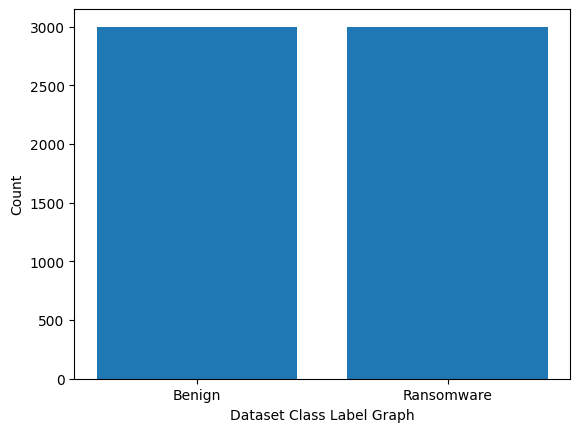

In [4]:
#find and plot graph of ransomware and benign from dataset where 0 label refers as benign and 1 refer as ransomware
#plot labels in dataset
labels, count = np.unique(dataset['label'], return_counts = True)
labels = ['Benign', 'Ransomware']
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [5]:
#dataset preprocessing such as normalization and shuffling
data = dataset.values
X = data[:,1:data.shape[1]-1]
Y = data[:,data.shape[1]-1]
Y = Y.astype(int)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle dataset values
X = X[indices]
Y = Y[indices]

scaler = MinMaxScaler((0,1))
X = scaler.fit_transform(X)#normalized or transform features
print("Normalized Features")
print(X)

Normalized Features
[[2.27890554e-01 5.03689209e-01 1.16539269e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.53095999e-03 8.80525022e-04 7.81269928e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.48949600e-01 5.78999996e-01 1.81797887e-01 ... 3.15485713e-02
  6.58083172e-05 0.00000000e+00]
 ...
 [8.41361927e-02 3.77235457e-03 4.31725746e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.59627543e-01 7.34952155e-04 1.18601942e-01 ... 4.45357954e-03
  0.00000000e+00 0.00000000e+00]
 [8.62609493e-02 6.31890381e-01 5.49405007e-02 ... 3.26101772e-02
  1.45098842e-03 3.13976126e-02]]


In [6]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 4800
Testing Size (20%): 1200



In [7]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [8]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


SVM Accuracy  : 88.08333333333334
SVM Precision   : 90.33783783783784
SVM Recall      : 88.14262023217248
SVM FMeasure    : 87.92595996006278


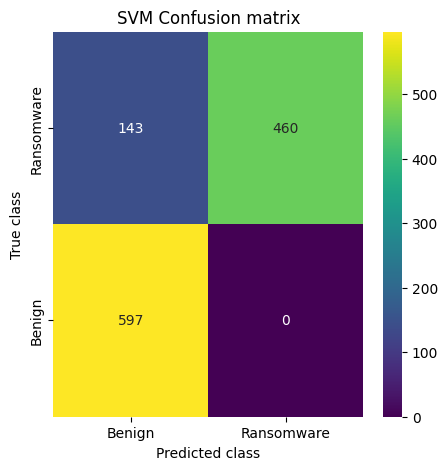

In [9]:
#now train SVM algorithm on training features and then test on testing features to calculate accuracy and other metrics
svm_cls = svm.SVC(kernel="poly", gamma="scale", C=0.004)
svm_cls.fit(X_train, y_train)
predict = svm_cls.predict(X_test)
calculateMetrics("SVM", predict, y_test)


KNN Accuracy  : 97.83333333333334
KNN Precision   : 97.8788527456764
KNN Recall      : 97.84161270698434
KNN FMeasure    : 97.83303838578028


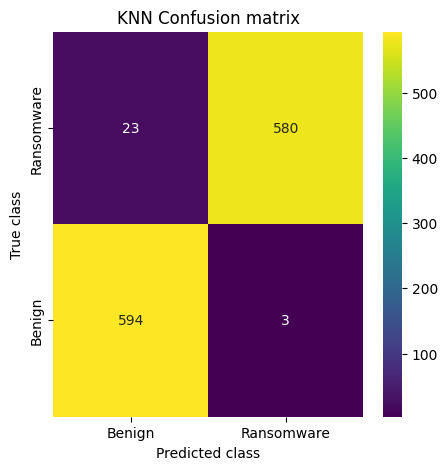

In [10]:
#now training KNN algorithm
knn_cls =  KNeighborsClassifier(n_neighbors=500)
knn_cls.fit(X_train, y_train)
predict = knn_cls.predict(X_test)
calculateMetrics("KNN", predict, y_test)


Decision Tree Accuracy  : 93.91666666666667
Decision Tree Precision   : 94.3553090546103
Decision Tree Recall      : 93.94193188163037
Decision Tree FMeasure    : 93.90386054037126


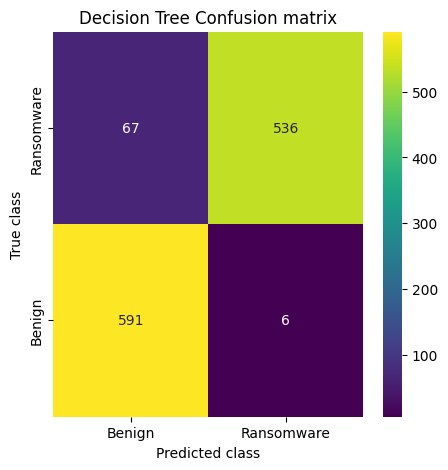

In [11]:
#now train decision tree classifier with hyper parameters
dt_cls = DecisionTreeClassifier(criterion = "entropy",max_leaf_nodes=2,max_features="auto")#giving hyper input parameter values
dt_cls.fit(X_train, y_train)
predict = dt_cls.predict(X_test)
calculateMetrics("Decision Tree", predict, y_test)


Random Forest Accuracy  : 93.91666666666667
Random Forest Precision   : 94.3553090546103
Random Forest Recall      : 93.94193188163037
Random Forest FMeasure    : 93.90386054037126


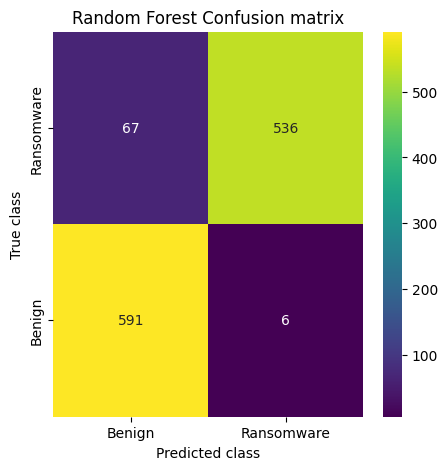

In [12]:
#training random Forest algortihm
rf = RandomForestClassifier(n_estimators=40, criterion='gini', max_features="log2", min_weight_fraction_leaf=0.3)
rf.fit(X_train, y_train)
predict = rf.predict(X_test)
calculateMetrics("Random Forest", predict, y_test)


XGBoost Accuracy  : 98.25
XGBoost Precision   : 98.30577776788793
XGBoost Recall      : 98.24203938431795
XGBoost FMeasure    : 98.24924012158054


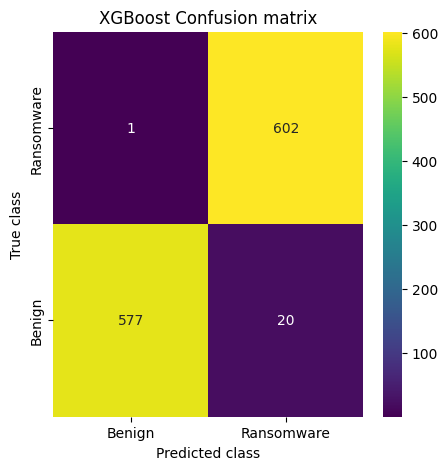

In [13]:
#now train XGBoost algorithm
xgb_cls = XGBClassifier(n_estimators=10,learning_rate=0.09,max_depth=2)
xgb_cls.fit(X_train, y_train)
predict = xgb_cls.predict(X_test)
calculateMetrics("XGBoost", predict, y_test)

Instructions for updating:
Colocations handled automatically by placer.

DNN Accuracy  : 90.25
DNN Precision   : 91.875
DNN Recall      : 90.20100502512562
DNN FMeasure    : 90.1464764178652


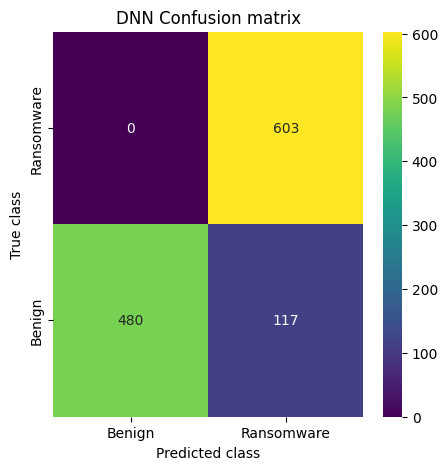

In [14]:
#train DNN algortihm
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
#define DNN object
dnn_model = Sequential()
#add DNN layers
dnn_model.add(Dense(2, input_shape=(X_train.shape[1],), activation='relu'))
dnn_model.add(Dense(2, activation='relu'))
dnn_model.add(Dropout(0.3))
dnn_model.add(Dense(y_train1.shape[1], activation='softmax'))
# compile the keras model
dnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#train and load the model
if os.path.exists("model/dnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/dnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = dnn_model.fit(X_train, y_train1, batch_size = 32, epochs = 10, validation_data=(X_test, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/dnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    dnn_model.load_weights("model/dnn_weights.hdf5")
#perform prediction on test data    
predict = dnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("DNN", predict, testY)#call function to calculate accuracy and other metrics



LSTM Accuracy  : 93.66666666666667
LSTM Precision   : 93.67274303384929
LSTM Recall      : 93.66400826687334
LSTM FMeasure    : 93.66603326999368


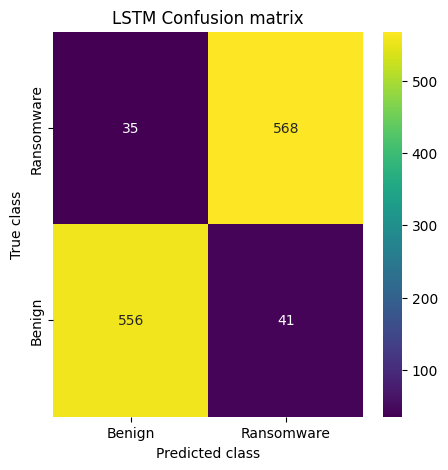

In [15]:
#now train LSTM algorithm
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()#defining deep learning sequential object
#adding LSTM layer with 100 filters to filter given input X train data to select relevant features
lstm_model.add(LSTM(32,input_shape=(X_train1.shape[1], X_train1.shape[2])))
#adding dropout layer to remove irrelevant features
lstm_model.add(Dropout(0.2))
#adding another layer
lstm_model.add(Dense(32, activation='relu'))
#defining output layer for prediction
lstm_model.add(Dense(y_train1.shape[1], activation='softmax'))
#compile LSTM model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#train and load the model
if os.path.exists("model/lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/lstm_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lstm_model.fit(X_train1, y_train1, batch_size = 32, epochs = 10, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/lstm_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    lstm_model.load_weights("model/lstm_weights.hdf5")
#perform prediction on test data    
predict = lstm_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("LSTM", predict, testY)#call function to calculate accuracy and other metrics


Extension CNN2D Accuracy  : 99.16666666666667
Extension CNN2D Precision   : 99.17216473366206
Extension CNN2D Recall      : 99.16997924948123
Extension CNN2D FMeasure    : 99.16666435184543


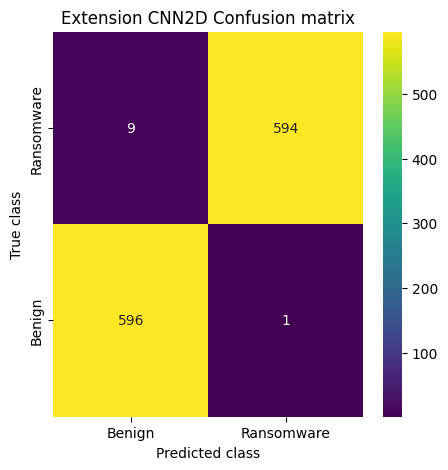

In [16]:
#now train extension CNN algorithm
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
#define extension CNN model object
cnn_model = Sequential()
#adding CNN layer wit 32 filters to optimized dataset features using 32 neurons
cnn_model.add(Convolution2D(64, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
#adding maxpooling layer to collect filtered relevant features from previous CNN layer
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#adding another CNN layer to further filtered features
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#collect relevant filtered features
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
#defining output layers
cnn_model.add(Dense(units = 256, activation = 'relu'))
#defining prediction layer with Y target data
cnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compile the CNN with LSTM model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train and load the model
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train1, y_train1, batch_size = 8, epochs = 10, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data        
predict = cnn_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("Extension CNN2D", predict, testY)#call function to calculate accuracy and other metrics

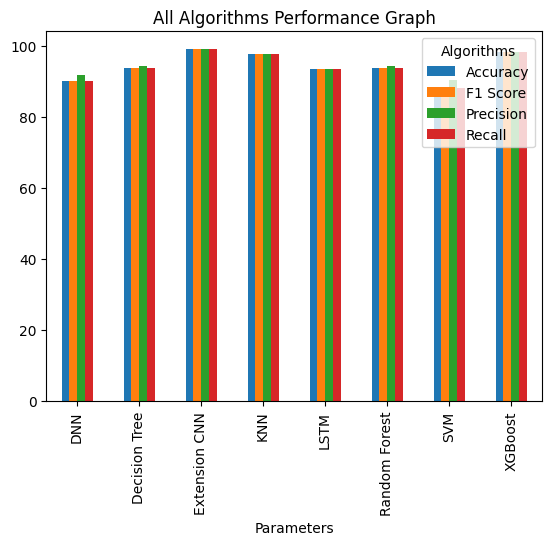

In [17]:
#plot comparison graph between all algorithms
df = pd.DataFrame([['SVM','Precision',precision[0]],['SVM','Recall',recall[0]],['SVM','F1 Score',fscore[0]],['SVM','Accuracy',accuracy[0]],
                   ['KNN','Precision',precision[1]],['KNN','Recall',recall[1]],['KNN','F1 Score',fscore[1]],['KNN','Accuracy',accuracy[1]],
                   ['Decision Tree','Precision',precision[2]],['Decision Tree','Recall',recall[2]],['Decision Tree','F1 Score',fscore[2]],['Decision Tree','Accuracy',accuracy[2]],
                   ['Random Forest','Precision',precision[3]],['Random Forest','Recall',recall[3]],['Random Forest','F1 Score',fscore[3]],['Random Forest','Accuracy',accuracy[3]],
                   ['XGBoost','Precision',precision[4]],['XGBoost','Recall',recall[4]],['XGBoost','F1 Score',fscore[4]],['XGBoost','Accuracy',accuracy[4]],
                   ['DNN','Precision',precision[5]],['DNN','Recall',recall[5]],['DNN','F1 Score',fscore[5]],['DNN','Accuracy',accuracy[5]],
                   ['LSTM','Precision',precision[6]],['LSTM','Recall',recall[6]],['LSTM','F1 Score',fscore[6]],['LSTM','Accuracy',accuracy[6]],
                   ['Extension CNN','Precision',precision[7]],['Extension CNN','Recall',recall[7]],['Extension CNN','F1 Score',fscore[7]],['Extension CNN','Accuracy',accuracy[7]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [18]:
#display all algorithm performnace in tabular format
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["SVM","KNN", "Decision Tree", "Random Forest", "XGBoost", "DNN", "LSTM", "Extension CNN"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,SVM,90.337838,88.142620,87.925960,88.083333
1,KNN,97.878853,97.841613,97.833038,97.833333
2,Decision Tree,94.355309,93.941932,93.903861,93.916667
3,Random Forest,94.355309,93.941932,93.903861,93.916667
4,XGBoost,98.305778,98.242039,98.249240,98.250000
5,DNN,91.875000,90.201005,90.146476,90.250000
6,LSTM,93.672743,93.664008,93.666033,93.666667
7,Extension CNN,99.172165,99.169979,99.166664,99.166667


In [19]:
#now read test data and then predict ransom or benign using extension CNN model
testData = pd.read_csv("Dataset/testData.csv")#reading test data
testData.fillna(0, inplace = True)
temp = testData.values
testData = testData.values
testData = testData[:,0:testData.shape[1]-1]
test = scaler.transform(testData)#normalizing values
test = np.reshape(test, (test.shape[0], test.shape[1], 1, 1))
predict = cnn_model.predict(test)#performing prediction on test data using extension CNN model
for i in range(len(predict)):
    pred = np.argmax(predict[i])
    print("Test Data = "+str(temp[i])+" Predicted AS ====> "+labels[pred]+"\n")

Test Data = [2.1506087e+07 8.5300000e+03 8.6983600e+05 5.8991000e+04 3.0000000e+00
 4.0000000e+00 2.4576000e+04 4.4000000e+01 1.3844480e+06 0.0000000e+00
 4.6274600e+05 1.0921356e+07 0.0000000e+00] Predicted AS ====> Benign

Test Data = [2.4040858e+07 6.2620000e+03 1.0111480e+06 8.8860000e+04 2.0000000e+00
 3.5000000e+01 7.9462400e+05 1.2000000e+01 2.4985600e+05 0.0000000e+00
 3.3243050e+06 1.2417450e+06 0.0000000e+00] Predicted AS ====> Ransomware

Test Data = [8.6719703e+07 2.3200000e+02 3.1320000e+03 2.0025900e+05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00] Predicted AS ====> Ransomware

Test Data = [8.6837894e+07 1.4700000e+02 3.7560000e+03 2.1272200e+05 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00] Predicted AS ====> Ransomware

Test Data = [4.8812020e+06 1.2856000e+04 3.3528000e+05 1.1150500e+05 7.0000000e+00
 0.00